In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = '/content/drive/MyDrive/dataset/dermoscopy'

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=(-40, 40)),
        transforms.RandomResizedCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

In [ ]:
import os
from torchvision.datasets import ImageFolder
normal_folder = os.path.join(dataset_path, 'HAM10000_images_part_1')
pneumonia_folder = os.path.join(dataset_path, 'HAM10000_images_part_2')
combined_dataset = ImageFolder(root=dataset_path, transform=data_transforms['train'])
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(combined_dataset, [train_size, val_size])
batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


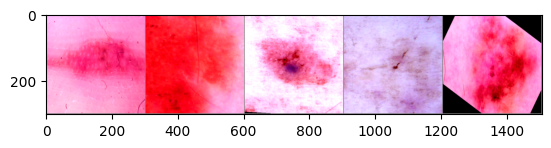

Labels: tensor([1, 0, 0, 0, 1])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, models, transforms, utils
inputs, labels = next(iter(train_loader))
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(utils.make_grid(inputs))
print('Labels:', labels)

In [ ]:
for images, labels in train_loader:
    print(images.size())
    break

torch.Size([5, 3, 299, 299])


In [ ]:
import os
normal_folder = os.path.join(dataset_path, 'benign')
pneumonia_folder = os.path.join(dataset_path, 'maligant')
print("Benign Samples:", len(os.listdir(normal_folder)))
print("Maligant Samples:", len(os.listdir(pneumonia_folder)))

normal Samples: 5
pneumonia Samples: 5


In [ ]:
for batch, labels in train_loader:
    print("Batch Shape:", batch.shape)
    print("Labels:", labels)
    break

Batch Shape: torch.Size([5, 3, 299, 299])
Labels: tensor([1, 0, 0, 1, 0])


In [ ]:
import torch.nn as nn
class DermoscopyEncoder(nn.Module):
    def __init__(self):
        super(DermoscopyEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, weight, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return x

encoder = DermoscopyEncoder()
weight = torch.randn(256)
for batch, labels in train_loader:
    features = encoder(weight, batch)
    print("Encoded Features Shape:", features.shape)
    break

Encoded Features Shape: torch.Size([5, 256])


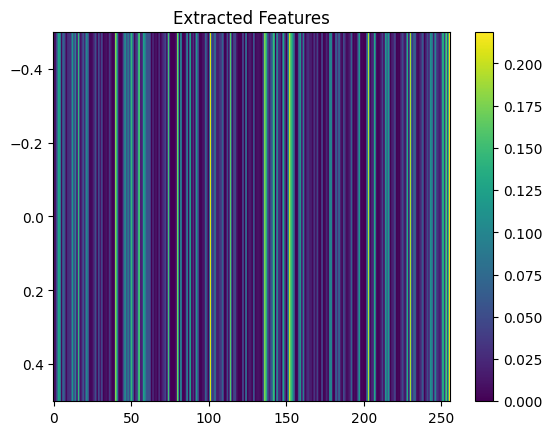

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
features_np = features.detach().cpu().numpy()  # Convert to NumPy array
feature_image = features_np[0]
# Display the feature heatmap
plt.imshow(feature_image.reshape(1, -1), cmap='viridis', aspect='auto')  # Assuming the features are 1D
plt.colorbar()
plt.title('Extracted Features')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class AACoder(nn.Module):
    def __init__(self, input_size, noise_size, output_size):
        super(AACoder, self).__init__()
        self.fc1 = nn.Linear(input_size + noise_size, output_size)
        self.fc2 = nn.Linear(output_size, input_size)
    def forward(self, original_features, gaussian_noise, weight):
        combined_features = torch.cat((original_features, gaussian_noise), dim=1)
        x = F.relu(self.fc1(combined_features))
        x = self.fc2(x)
        return x
input_size = features.size(1) 
noise_size = 100  
output_size = 256
aacoder = AACoder(input_size, noise_size, output_size)
gaussian_noise = torch.randn(features.size(0), noise_size) 
aacoder_weight = torch.randn(output_size)
attack_features = aacoder(features, gaussian_noise, aacoder_weight)

In [ ]:
import torch
import torch.nn as nn
class ReconstructionBlock(nn.Module):
    def __init__(self, input_size, output_size):
        super(ReconstructionBlock, self).__init__()
        self.fc = nn.Linear(input_size, output_size)  
    def forward(self, input_features):
        return self.fc(input_features)
class AttentionBlock(nn.Module):
    def __init__(self, input_size, output_size):
        super(AttentionBlock, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.sigmoid = nn.Sigmoid()
    def forward(self, classification_features):
        attention_features = self.sigmoid(self.fc(classification_features))
        return attention_features
class CombineBlock(nn.Module):
    def __init__(self):
        super(CombineBlock, self).__init__()
    def forward(self, perturbation_restoration, attention_features):
        final_perturbation = perturbation_restoration * attention_features
        return final_perturbation
class Decoder(nn.Module):
    def __init__(self, reconstruction_input_size, attention_input_size, perturbation_restoration_output_size):
        super(Decoder, self).__init__()
        self.reconstruction_block = ReconstructionBlock(reconstruction_input_size, perturbation_restoration_output_size)
        self.attention_block = AttentionBlock(attention_input_size, perturbation_restoration_output_size)
        self.combine_block = CombineBlock()
    def forward(self, classification_features, attack_features):
        attention_features = self.attention_block(classification_features)
        perturbation_restoration = self.reconstruction_block(attack_features)
        final_perturbation = self.combine_block(perturbation_restoration, attention_features)
        return final_perturbation
dermoscopy_encoder_output_size = 256
aacoder_output_size = 256
decoder_output_size = 256
reconstruction_input_size = aacoder_output_size  
attention_input_size = dermoscopy_encoder_output_size  
perturbation_restoration_output_size = decoder_output_size  
decoder = Decoder(reconstruction_input_size, attention_input_size, perturbation_restoration_output_size)
classification_features = torch.randn(5, attention_input_size)  
attack_features = torch.randn(5, reconstruction_input_size)     
final_perturbation = decoder(classification_features, attack_features)
print("Final Perturbation Shape:", final_perturbation.shape)


Final Perturbation Shape: torch.Size([5, 256])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
input_size = 256 
hidden_size = 64  
output_size = 256 
discriminator = Discriminator(input_size, hidden_size, output_size)
def wasserstein_distance(features1, features2):
    min_batch_size = min(features1.size(0), features2.size(0))
    features1 = features1[:min_batch_size]
    features2 = features2[:min_batch_size]
    w_distance = torch.mean(features1 - features2)
    return w_distance

In [ ]:
import torchvision.models as models
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetClassifier, self).__init__()
        resnet = models.resnet18(pretrained=False)
        in_features = resnet.fc.in_features
        resnet.fc = nn.Linear(in_features, num_classes)
        self.resnet = resnet
    def forward(self, x):
        return self.resnet(x)
resnet_classifier = ResNetClassifier(num_classes=2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
def carlini_wagner_loss(outputs, targets, confidence, targeted):
    one_hot_targets = torch.eye(outputs.shape[1])[targets].to(outputs.device)
    real = (one_hot_targets * outputs).sum(dim=1)
    other = ((1.0 - one_hot_targets) * outputs - one_hot_targets * 10000.0).max(dim=1)[0]
    if targeted:
        loss = torch.clamp(other - real + confidence, min=0.0)
    else:
        loss = torch.clamp(real - other + confidence, min=0.0)
    return loss.mean()

In [ ]:
def pgd_cw_defense(model, adversarial_samples, epsilon=0.3, alpha=0.01, num_iter=40, confidence=0, targeted=False, random_start=True):
    device = adversarial_samples.device
    if random_start:
        perturbation = torch.rand_like(adversarial_samples, requires_grad=True)
        perturbation.data = perturbation.data * 2 * epsilon - epsilon
    else:
        perturbation = torch.zeros_like(adversarial_samples, requires_grad=True)
    for _ in range(num_iter):
        output = model(adversarial_samples + perturbation)
        loss = carlini_wagner_loss(output, torch.ones_like(output).argmax(dim=1), confidence=confidence, targeted=targeted)
        grad = torch.autograd.grad(loss, perturbation)[0]
        perturbation = (perturbation + alpha * torch.sign(grad)).clamp(-epsilon, epsilon)
        perturbation = torch.max(torch.min(adversarial_samples + perturbation, torch.tensor(1.0).to(device)), torch.tensor(0.0).to(device)) - adversarial_samples
    defended_batch = adversarial_samples + perturbation
    flattened_samples = defended_batch.view(defended_batch.size(0), -1)
    return flattened_samples


In [ ]:
threshold = 0.5  
for i, (batch, labels) in enumerate(train_loader):
    original_features = encoder(weight, batch)
    gaussian_noise = torch.randn(original_features.size(0), noise_size)
    attack_features = aacoder(original_features, gaussian_noise, aacoder_weight)
    restored_perturbations = decoder(original_features, attack_features)
    restored_perturbations_reshaped = restored_perturbations.view(restored_perturbations.size(0), -1, 1, 1)
    num_channels_original = batch.size(1)
    num_channels_perturbations = restored_perturbations_reshaped.size(1)
    if num_channels_original != num_channels_perturbations:
        restored_perturbations_reshaped = restored_perturbations_reshaped[:, :num_channels_original, :, :]
    adversarial_sample = batch + restored_perturbations_reshaped
    adversarial_samples= pgd_cw_defense(resnet_classifier, adversarial_sample)
    resized_batch = batch.view(batch.size(0), -1)[:, :256]  
    discriminator_output = discriminator(resized_batch)
    w_distance = wasserstein_distance(original_features, discriminator_output)
    classified_sample = "real" if w_distance >= threshold else "fake"
    for j in range(len(batch)):
        print(f"Sample {i+1}, Adversarial Sample {j+1}: {classified_sample}")
    break


Sample 1, Adversarial Sample 1: fake
Sample 1, Adversarial Sample 2: fake
Sample 1, Adversarial Sample 3: fake
Sample 1, Adversarial Sample 4: fake
Sample 1, Adversarial Sample 5: fake


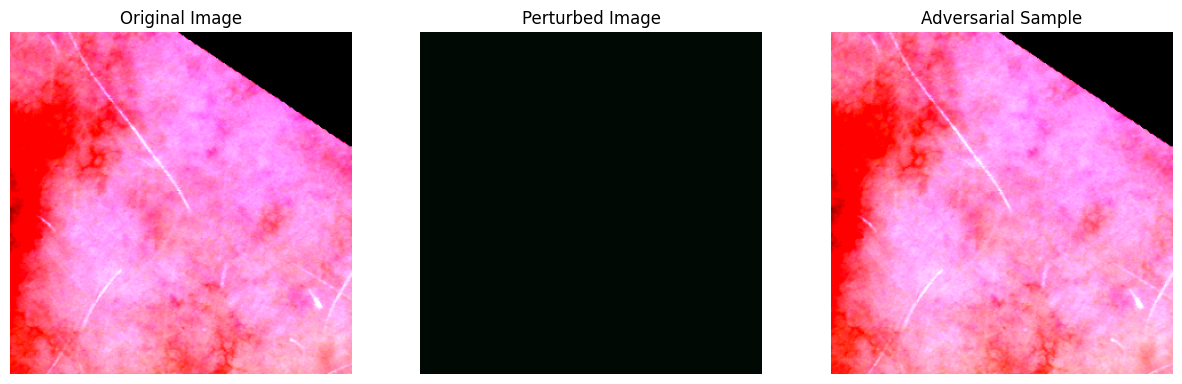

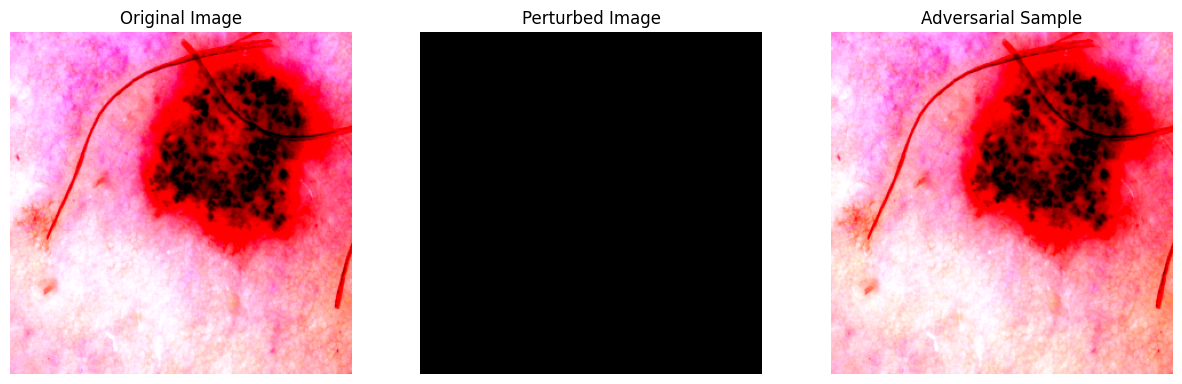

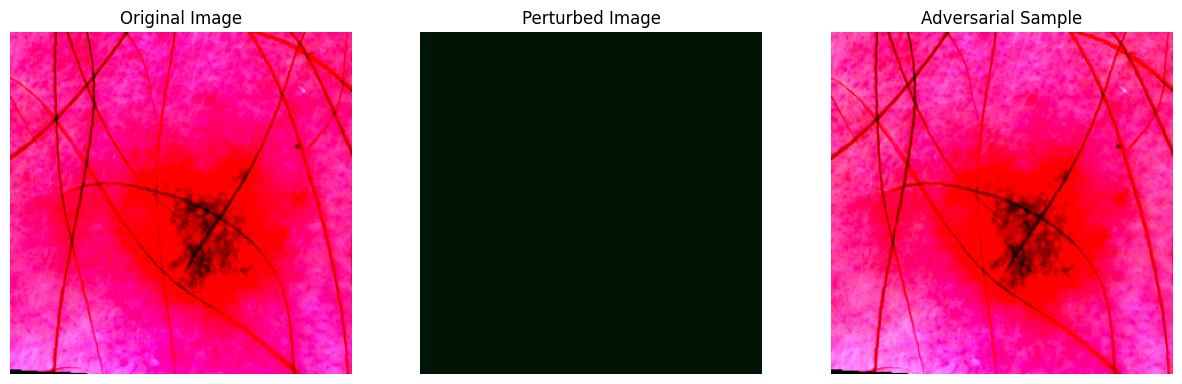

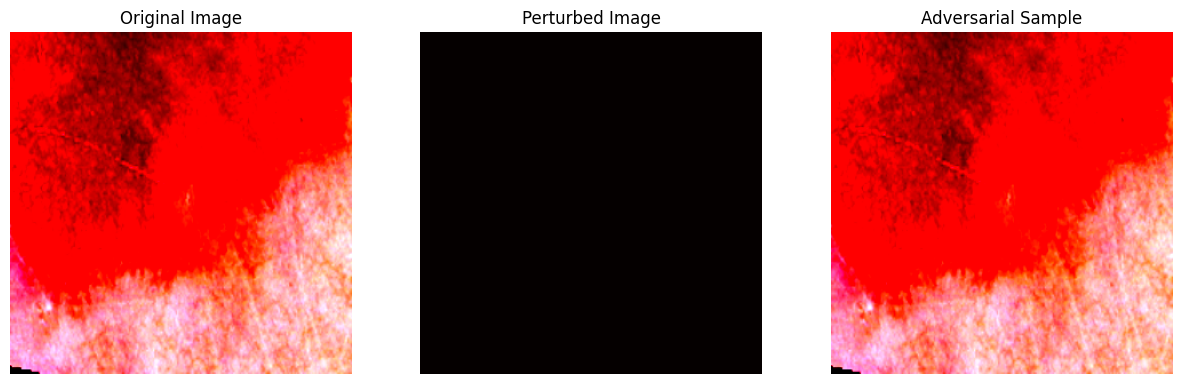

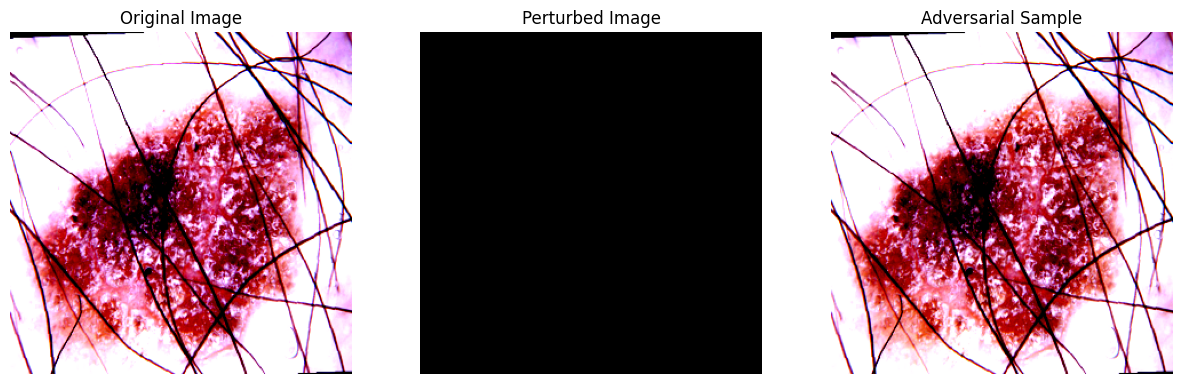

In [ ]:
def visualize_samples(original, perturbed, adversarial):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    titles = ['Original Image', 'Perturbed Image', 'Adversarial Sample']
    samples = [original, perturbed, adversarial]
    for ax, title, sample in zip(axes, titles, samples):
        ax.imshow(np.transpose(sample.detach().numpy(), (1, 2, 0)))
        ax.set_title(title)
        ax.axis('off')
    plt.show()
for batch, labels in train_loader:
    original_features = encoder(weight, batch)
    gaussian_noise = torch.randn(original_features.size(0), noise_size)
    attack_features = aacoder(original_features, gaussian_noise, aacoder_weight)
    restored_perturbations = decoder(original_features, attack_features)
    restored_perturbations_reshaped = restored_perturbations.view(restored_perturbations.size(0), -1, 1, 1)
    num_channels_original = batch.size(1)
    num_channels_perturbations = restored_perturbations_reshaped.size(1)
    if num_channels_original != num_channels_perturbations:
        restored_perturbations_reshaped = restored_perturbations_reshaped[:, :num_channels_original, :, :]
    adversarial_samples = batch + restored_perturbations_reshaped
    defended_batch = pgd_cw_defense(resnet_classifier, adversarial_samples)
    for i in range(len(batch)):
        visualize_samples(batch[i], restored_perturbations_reshaped[i], adversarial_samples[i])
    break

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
resnet50 = models.resnet50(pretrained=True)
densenet121 = models.densenet121(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
num_classes = 2 
resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, num_classes)
densenet121.classifier = torch.nn.Linear(densenet121.classifier.in_features, num_classes)
vgg16.classifier[6] = torch.nn.Linear(vgg16.classifier[6].in_features, num_classes)
resnet50.eval()
densenet121.eval()
vgg16.eval()
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
import torch
import torch.nn.functional as F
alpha = 1.0
beta = 1.0
gamma = 1.0
c = 0.1 
def calculate_adversarial_classification_loss(outputs, labels):
    return F.cross_entropy(outputs, labels)
def calculate_adversarial_generation_loss(discriminator_outputs):
    return torch.mean(1 - discriminator_outputs)
def calculate_perturbation_magnitude_loss(perturbation):
    return torch.mean(torch.max(torch.tensor(0.0), torch.norm(perturbation, p=2) - c))
def calculate_feature_consistency_loss(features_original, features_perturbed):
    return F.mse_loss(features_original, features_perturbed)
for batch, labels in train_loader:
    original_features = encoder(weight, batch)
    gaussian_noise = torch.randn(original_features.size(0), noise_size)
    attack_features = aacoder(original_features, gaussian_noise, aacoder_weight)
    restored_perturbations = decoder(original_features, attack_features)
    restored_perturbations_reshaped = restored_perturbations.view(restored_perturbations.size(0), -1, 1, 1)
    num_channels_original = batch.size(1)
    num_channels_perturbations = restored_perturbations_reshaped.size(1)
    if num_channels_original != num_channels_perturbations:
        restored_perturbations_reshaped = restored_perturbations_reshaped[:, :num_channels_original, :, :]
    adversarial_samples = batch + restored_perturbations_reshaped
    resnet_outputs = resnet50(adversarial_samples)
    densenet_outputs = densenet121(adversarial_samples)
    vgg16_outputs = vgg16(adversarial_samples)
    loss_resnet = calculate_adversarial_classification_loss(resnet_outputs, labels)
    loss_densenet = calculate_adversarial_classification_loss(densenet_outputs, labels)
    loss_vgg16 = calculate_adversarial_classification_loss(vgg16_outputs, labels)
    print("Adversarial Classification Loss (ResNet-50):", loss_resnet.item())
    print("Adversarial Classification Loss (DenseNet-121):", loss_densenet.item())
    print("Adversarial Classification Loss (VGG-16):", loss_vgg16.item())
    break

Adversarial Classification Loss (ResNet-50): 0.7063578367233276
Adversarial Classification Loss (DenseNet-121): 0.7474455833435059
Adversarial Classification Loss (VGG-16): 0.7148885130882263


In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
resnet50 = models.resnet50(pretrained=True)
densenet121 = models.densenet121(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
num_classes = 2  
resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, num_classes)
densenet121.classifier = torch.nn.Linear(densenet121.classifier.in_features, num_classes)
vgg16.classifier[6] = torch.nn.Linear(vgg16.classifier[6].in_features, num_classes)
resnet50.eval()
densenet121.eval()
vgg16.eval()
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 94.8MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Do

In [ ]:
from sklearn.metrics import accuracy_score
for batch, labels in train_loader:
    resnet_outputs = resnet50(batch)
    densenet_outputs = densenet121(batch)
    vgg16_outputs = vgg16(batch)
    resnet_preds = torch.argmax(resnet_outputs, dim=1).cpu().numpy()
    densenet_preds = torch.argmax(densenet_outputs, dim=1).cpu().numpy()
    vgg16_preds = torch.argmax(vgg16_outputs, dim=1).cpu().numpy()
    accuracy_resnet = accuracy_score(labels.cpu().numpy(), resnet_preds)
    accuracy_densenet = accuracy_score(labels.cpu().numpy(), densenet_preds)
    accuracy_vgg16 = accuracy_score(labels.cpu().numpy(), vgg16_preds)
    print("Accuracy (ResNet-50, DenseNet-121, VGG-16):", accuracy_resnet, accuracy_densenet, accuracy_vgg16)
    break


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy (ResNet-50, DenseNet-121, VGG-16): 0.6 0.6 0.8


In [ ]:
from sklearn.metrics import roc_auc_score
for batch, labels in train_loader:
    resnet_outputs = resnet50(batch)
    densenet_outputs = densenet121(batch)
    vgg16_outputs = vgg16(batch)
    resnet_preds = torch.argmax(resnet_outputs, dim=1).cpu().numpy()
    densenet_preds = torch.argmax(densenet_outputs, dim=1).cpu().numpy()
    vgg16_preds = torch.argmax(vgg16_outputs, dim=1).cpu().numpy()
    auc_resnet = roc_auc_score(labels.cpu().numpy(), resnet_outputs[:, 1].detach().cpu().numpy())
    auc_densenet = roc_auc_score(labels.cpu().numpy(), densenet_outputs[:, 1].detach().cpu().numpy())
    auc_vgg16 = roc_auc_score(labels.cpu().numpy(), vgg16_outputs[:, 1].detach().cpu().numpy())
    print("AUC (ResNet-50, DenseNet-121, VGG-16):", auc_resnet, auc_densenet, auc_vgg16)
    break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


AUC (ResNet-50, DenseNet-121, VGG-16): 0.5 0.33333333333333337 0.5


In [ ]:
import numpy as np
def calculate_l2_norm(original_images, adversarial_samples):
    l2_norms = []
    for original_image, adversarial_sample in zip(original_images, adversarial_samples):
        original_image_reshaped = original_image.reshape(3, 299, 299)
        adversarial_sample_reshaped = adversarial_sample.reshape(3, 299, 299)
        perturbation = adversarial_sample_reshaped - original_image_reshaped
        l2_norm = np.linalg.norm(perturbation)
        l2_norms.append(l2_norm)
    return l2_norms


In [ ]:
import numpy as np
for batch, labels in train_loader:
    resnet_outputs = resnet50(batch)
    densenet_outputs = densenet121(batch)
    vgg16_outputs = vgg16(batch)
    l2_norm_resnet = calculate_l2_norm(batch.detach().cpu().numpy(), adversarial_sample.detach().cpu().numpy())
    l2_norm_densenet = calculate_l2_norm(batch.detach().cpu().numpy(), adversarial_sample.detach().cpu().numpy())
    l2_norm_vgg16 = calculate_l2_norm(batch.detach().cpu().numpy(), adversarial_sample.detach().cpu().numpy())
    print("L2 Norm (ResNet-50):", l2_norm_resnet)
    print("L2 Norm (DenseNet-121):", l2_norm_densenet)
    print("L2 Norm (VGG-16):", l2_norm_vgg16)
    break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2 Norm (ResNet-50): [504.95255, 739.1714, 349.30795, 621.80005, 473.3899]
L2 Norm (DenseNet-121): [504.95255, 739.1714, 349.30795, 621.80005, 473.3899]
L2 Norm (VGG-16): [504.95255, 739.1714, 349.30795, 621.80005, 473.3899]


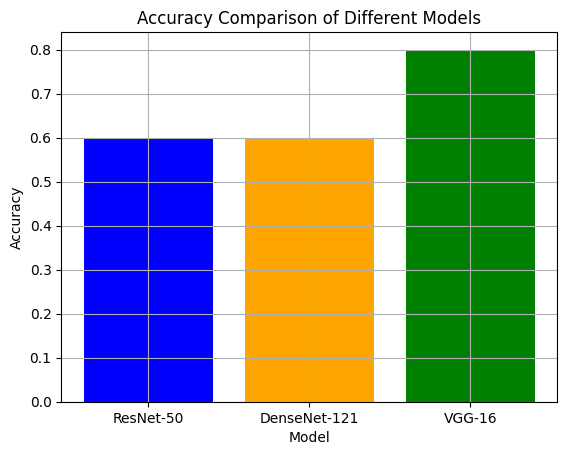

In [ ]:
import matplotlib.pyplot as plt
models = ['ResNet-50', 'DenseNet-121', 'VGG-16']
accuracies = [accuracy_resnet, accuracy_densenet, accuracy_vgg16] 
plt.bar(models, accuracies, color=['blue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.grid(True)
plt.show()
